In [1]:
%matplotlib inline
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
import json
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from datetime import datetime

from IPython.display import display
import ipywidgets as widgets

from folium.plugins import HeatMap
import seaborn as sns

import data_filtering

# Import incident data

In [2]:
#Extract subnetwork
highway_shapefile = 'Data/Shapefiles/Snelheid_Wegvakken.shp'
network_temp = gpd.read_file(highway_shapefile)
#network_temp.plot()

In [22]:
path = 'Data/incidents19Q3Q4.csv'
df_incident = pd.read_csv(path)
len(df_incident)
path1 = 'Data/incidents19Q3Q4.csv'
df_incident_unfilter = pd.read_csv(path1)


In [4]:
df_incident['starttime_new'] = pd.to_datetime(df_incident['starttime_new'])
df_incident['endtime_new'] = pd.to_datetime(df_incident['endtime_new'])

In [5]:
# filter the data
df_incident = data_filtering.filter_out(df_incident, network_temp)

In [9]:
len(df_incident)

75679

# Distribution of incidents over time

In [10]:
def distribution_in_day(df_incident):
    df_incident['starttime_new'] = pd.to_datetime(df_incident['starttime_new'])
    df_incident['endtime_new'] = pd.to_datetime(df_incident['endtime_new'])
    df_incident['Hour'] = df_incident['starttime_new'].dt.hour

    hourly_counts = df_incident.groupby(['type', 'Hour']).size().unstack(fill_value=0)

    def plot_accidents(accident_type):
        if accident_type == 'all':
            filtered_df = df_incident
        else:
            filtered_df = df_incident[df_incident['type'] == accident_type]

        hourly_counts = filtered_df['Hour'].value_counts().sort_index()
        plt.figure(figsize=(10, 6))
        plt.bar(hourly_counts.index, hourly_counts.values)
        plt.title(f'Hourly Distribution of {accident_type} Incidents')
        plt.xlabel('Hour')
        plt.ylabel('Number of Incidents')
        plt.xticks(range(24))
        plt.show()

    # Get all different incident types, including "all incidents"
    accident_types = ['all'] + list(df_incident['type'].unique())

    # Create drop-down menu
    dropdown = widgets.Dropdown(options=accident_types, description='Incident Type:')
    output = widgets.interactive(plot_accidents, accident_type=dropdown)

    # show the figure
    display(output)

In [11]:
distribution_in_day(df_incident)

interactive(children=(Dropdown(description='Incident Type:', options=('all', 'vehicle_obstruction', 'general_o…

In [12]:
def distribution_in_week(df_incident):
    df_incident['starttime_new'] = pd.to_datetime(df_incident['starttime_new'])
    df_incident['endtime_new'] = pd.to_datetime(df_incident['endtime_new'])
    df_incident['Day_of_Week'] = df_incident['starttime_new'].dt.dayofweek

    def plot_accidents(accident_type):
        if accident_type == 'all':
            filtered_df = df_incident
        else:
            filtered_df = df_incident[df_incident['type'] == accident_type]

        daily_counts = filtered_df['Day_of_Week'].value_counts().sort_index()
        days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        daily_counts.index = days[:len(daily_counts)] 
        plt.figure(figsize=(10, 6))
        plt.bar(daily_counts.index, daily_counts.values)
        plt.title(f'Daily Distribution of {accident_type} Incidents')
        plt.xlabel('Day of the Week')
        plt.ylabel('Number of Incidents')
        plt.xticks(rotation=45)
        plt.show()

    accident_types = ['all'] + list(df_incident['type'].unique())

    dropdown = widgets.Dropdown(options=accident_types, description='Incident Type:')
    output = widgets.interactive(plot_accidents, accident_type=dropdown)
    
    display(output)




In [13]:
distribution_in_week(df_incident)

interactive(children=(Dropdown(description='Incident Type:', options=('all', 'vehicle_obstruction', 'general_o…

In [14]:
def distribution_in_year(df_incident):
    df_incident['starttime_new'] = pd.to_datetime(df_incident['starttime_new'])
    df_incident['endtime_new'] = pd.to_datetime(df_incident['endtime_new'])
    df_incident['Month'] = df_incident['starttime_new'].dt.month

    def plot_monthly_distribution(accident_type):
        if accident_type == 'all':
            filtered_df = df_incident
        else:
            filtered_df = df_incident[df_incident['type'] == accident_type]

        monthly_counts = filtered_df['Month'].value_counts().sort_index()
        plt.figure(figsize=(10, 6))
        plt.bar(monthly_counts.index, monthly_counts.values)
        plt.title(f'Monthly Distribution of {accident_type} Incidents')
        plt.xlabel('Month')
        plt.ylabel('Number of Incidents')
        plt.xticks(range(7, 13)) 
        plt.show()

    accident_types = ['all'] + list(df_incident['type'].unique())

    dropdown = widgets.Dropdown(options=accident_types, description='Incident Type:')
    output = widgets.interactive(plot_monthly_distribution, accident_type=dropdown)

    display(output)

In [15]:
distribution_in_year(df_incident)

interactive(children=(Dropdown(description='Incident Type:', options=('all', 'vehicle_obstruction', 'general_o…

In [16]:
def distribution_time(df, time):
    if time == 'day':
        distribution_in_day(df)
    if time == 'week':
        distribution_in_week(df)
    if time == 'year':
        distribution_in_year(df)


In [17]:
distribution_time(df_incident, 'day')

interactive(children=(Dropdown(description='Incident Type:', options=('all', 'vehicle_obstruction', 'general_o…

# Duration of incident

In [18]:
def distribution_duration(df_incident):
    df_incident['starttime_new'] = pd.to_datetime(df_incident['starttime_new'])
    df_incident['endtime_new'] = pd.to_datetime(df_incident['endtime_new'])

    df_incident['Duration_Minutes'] = (df_incident['endtime_new'] - df_incident['starttime_new']).dt.total_seconds() / 60
    df_incident = df_incident[(df_incident['Duration_Minutes'] <= 500) & (df_incident['Duration_Minutes'] > 0)]

    def plot_duration_distribution(accident_type):
        if accident_type == 'all':
            filtered_df = df_incident
        else:
            filtered_df = df_incident[df_incident['type'] == accident_type]

        plt.figure(figsize=(10, 6))
        plt.hist(filtered_df['Duration_Minutes'], bins=20, edgecolor='k')
        plt.title(f'Duration Distribution of {accident_type} Incidents')
        plt.xlabel('Duration (Minutes)')
        plt.ylabel('Number of Incidents')
        plt.show()

    accident_types = ['all'] + list(df_incident['type'].unique())

    dropdown = widgets.Dropdown(options=accident_types, description='Incident Type:')
    output = widgets.interactive(plot_duration_distribution, accident_type=dropdown)

    display(output)


In [19]:
distribution_duration(df_incident)

interactive(children=(Dropdown(description='Incident Type:', options=('all', 'vehicle_obstruction', 'general_o…

# Type of incidents

In [20]:
def type_distribution(df):
    incident_counts = df['type'].value_counts()
    plt.figure(figsize=(10, 6))
    plt.pie(incident_counts, labels=incident_counts.index, autopct='%1.1f%%', startangle=140)
    plt.xlabel('Incident Type')
    #plt.ylabel('Number of Incidents')
    plt.title('Incident Type Distribution')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

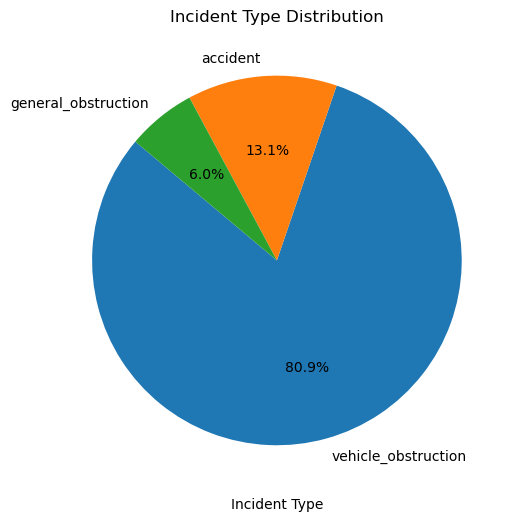

In [21]:
type_distribution(df_incident)

# Number of accidents that occurred at the same time

In [53]:
def simultaneous_accidents(df):
    df['starttime_new'] = pd.to_datetime(df['starttime_new'])

    # Sort data to ensure correct chronological order
    df = df.sort_values(by='starttime_new')
    # Use a one-hour window to count the number of accidents in every 15 minutes
    counts = df.resample('15T', on='starttime_new').size()

    # Find the time with the most accidents
    max_time = counts.idxmax()
    max_incidents = counts.max()

    plt.figure(figsize=(40, 6))
    plt.plot(counts.index, counts.values, marker='o', linestyle='-')
    plt.xlabel('Time')
    plt.ylabel('Number of Incidents')
    plt.title('Incident Count by every 15 minutes')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.show()
    return max_time, max_incidents

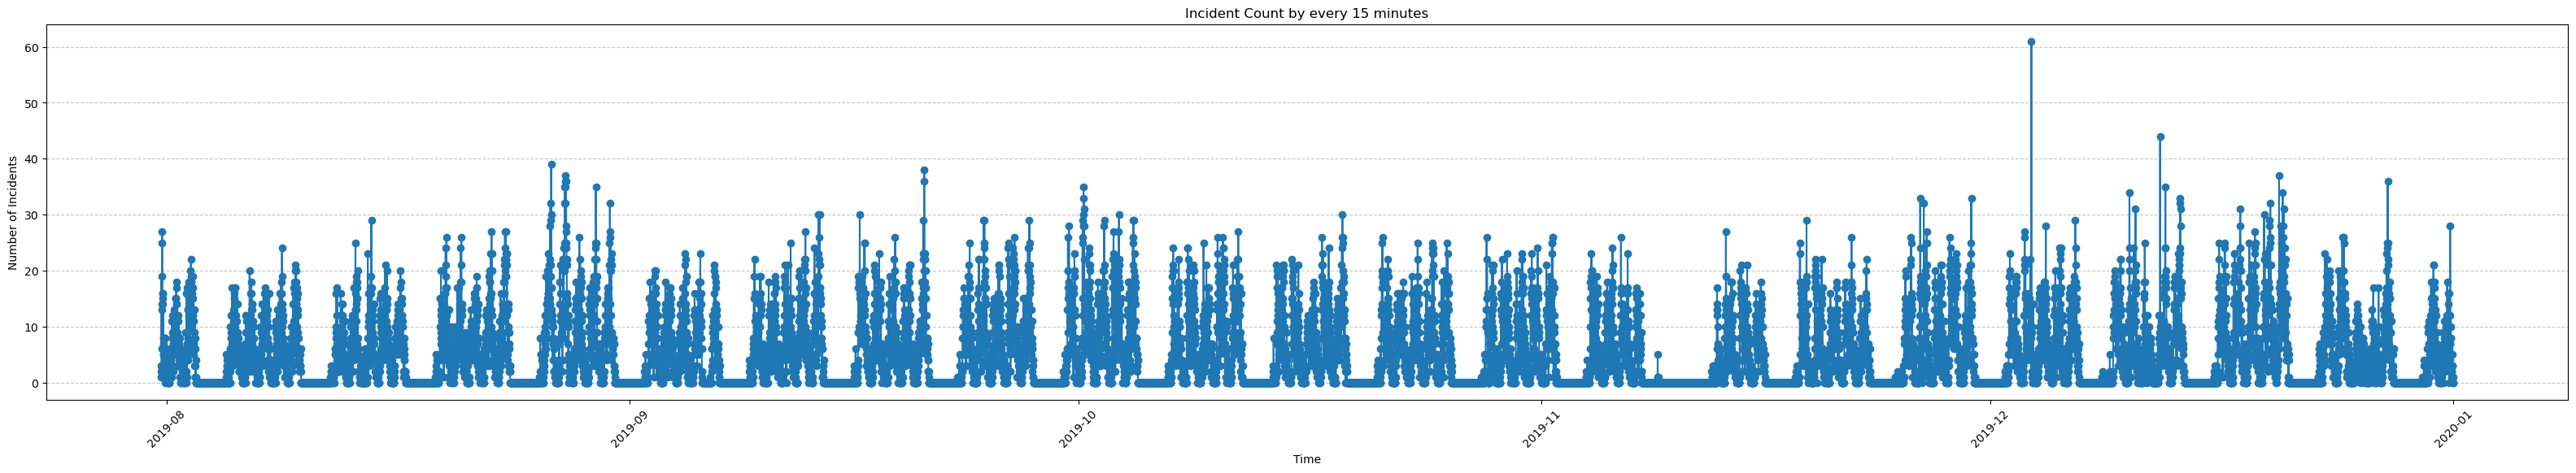

(Timestamp('2019-12-03 18:15:00'), 61)

In [54]:
simultaneous_accidents(df_incident)

# Map of Incident and Network 

In [10]:
def import_network_to_map(file_path):
    network_temp = gpd.read_file(file_path)
    
    #transform  DutchRD to WGS84
    network_temp = network_temp.to_crs("EPSG:4326")
    map = folium.Map(location=[52.399190, 4.893658])
    gjson = folium.features.GeoJson(
        network_temp,
    ).add_to(map)
    return map
    
    

In [11]:
def add_point_to_map(df_incident, map):
    # use MarkerCluster to show the points and cluster them
    marker_cluster = MarkerCluster().add_to(map)
    
    for _, row in df_incident.iterrows():
        popup_content = f"ID: {row['id']}<br>Type: {row['type']}<br>Start time: {row['starttime_new']}"
        folium.Marker(
            location=[row['primaire_locatie_breedtegraad'], row['primaire_locatie_lengtegraad']],
            popup=popup_content,
            icon=folium.Icon(color='red')
            ).add_to(marker_cluster)
    
    # save the map
    map.save('incidents_map_test2.html')
    return map

In [13]:
map = import_network_to_map('Data/Shapefiles/Snelheid_Wegvakken.shp')

In [14]:
map = add_point_to_map(df_incident, map)

In the function import_network_to_map, we import the network on the map and import the point data into the map in the functioin add_point_to_map. The point data of incidents imported in the map includes the ID, type and start time of the incident. And the functioin add_point_to_map clustered all points automatically while while importing them. When the map is zoomed in or out, points within the view will be reclustered. At the same time, click on the cluster and it will be divided into smaller clusters until it becomes a point. In the results, when the view is zoomed in to the whole country, all incident points are divided into 8 clusters. Among them, the cluster in the Amsterdam-The Hague-Rotterdam area contains the vast majority of incident points, with as many as 49,732, more than half of the total. The cluster in the Eindhoven area has the second most points, with a total of 11,578. However, clusters in the northeast and southwest regions of the country contain relatively few points.

# Heat Map

In [23]:
def create_heatmap(df_incident, map):
    # Create a list of points from the DataFrame
    locations = df_incident[['primaire_locatie_breedtegraad', 'primaire_locatie_lengtegraad']].values.tolist()

    # Create the HeatMap layer
    heatmap = HeatMap(locations)

    # Add the HeatMap layer to the map
    heatmap.add_to(map)

    # Save the map
    map.save('heatmap.html')

    return map


In [24]:
heatmap = create_heatmap(df_incident, map)

In [29]:
def heatmap_simple(df, network_temp):
    network_temp = network_temp.to_crs("EPSG:4326")
    plt.figure(figsize=(10, 8))
    sns.kdeplot(data=df, x="primaire_locatie_lengtegraad", y="primaire_locatie_breedtegraad", fill=True, cmap="YlOrRd", thresh=0.5)
    plt.title("Traffic Accident Heatmap")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    ax = plt.gca()
    network_temp.plot(ax=ax, color='blue', linewidth=0.5, label='network')
    plt.show()

d:\anaconda\envs\geospatial\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\anaconda\envs\geospatial\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\anaconda\envs\geospatial\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
d:\anaconda\envs\geospatial\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead

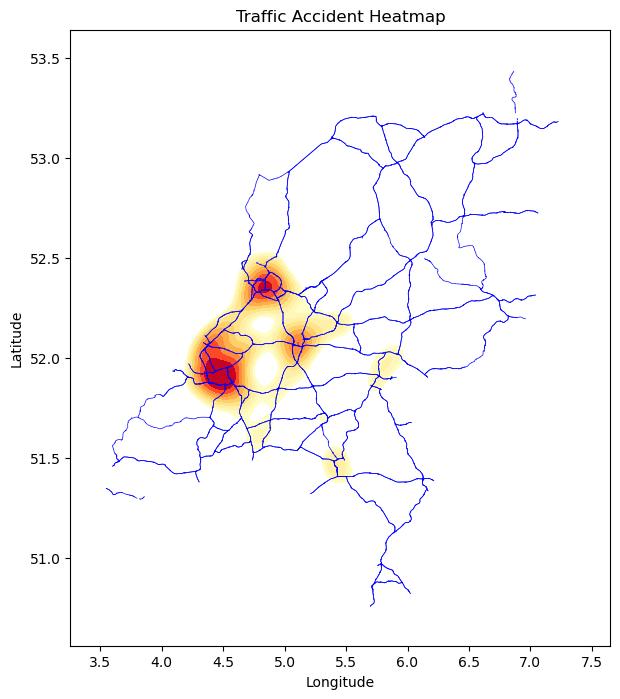

In [30]:
heatmap_simple(df_incident, network_temp)

In the function create_heatmap, we originally planned to project the point data onto the map in the form of a heat map through folium.plugins.heatmap. However, due to too much point data, the results are not ideal. Almost all areas around the road network are red with high incident rates. However, due to too much point data, the results are not ideal. Almost all areas around the road network are red with high incident rates. In order to highlight the high-incident areas, in the function heatmap_simple, we use heatmap_simple's kdeplot to draw the heat map. Considering the function's running speed, we only project it into the road network instead of the entire map. Its results clearly show three high-incidence areas, the largest of which is the Hague-Rotterdam area, followed by the Amsterdam area and finally the Utrecht area. All three areas show a distinct red color. Then there are two yellow zones, Eindhoven and Arnhem.

# Spatio-Temporal Map

In [24]:
def spatio_temporal(df_incident, network_temp, timestep):
    #df_incident: dataframe of incident
    #network_temp
    #timestep: time window (min)
    # transform GIS
    network_temp = network_temp.to_crs("EPSG:4326")

    # Convert starttime_new column to datetime object
    df_incident['starttime_new'] = pd.to_datetime(df_incident['starttime_new'])

    # Calculate the time window to which each time point belongs
    time_interval = pd.Timedelta(minutes=timestep)
    df_incident['time_window_start'] = df_incident['starttime_new'] - ((df_incident['starttime_new'] - df_incident['starttime_new'].min()) % time_interval)

    # List of options for creating a slider timeline
    time_window_options = df_incident['time_window_start'].unique()
    time_window_options = sorted(time_window_options)

    # creat the slider
    time_window_slider = widgets.SelectionSlider(
        options=time_window_options,
        description='time window:',
        continuous_update=False
    )

    def plot_accidents(time_window_start):
        selected_data = df_incident[df_incident['time_window_start'] == time_window_start]

        fig, ax = plt.subplots(figsize=(10, 8))
        network_temp.plot(ax=ax, color='blue', linewidth=0.5, label='network')
        
        # Define colors for different accident types
        colors = {'general_obstruction': 'red', 'vehicle_obstruction': 'green', 'accident': 'm'}  # Replace with your actual types and corresponding colors
        
        for acc_type, acc_data in selected_data.groupby('type'):
            plt.scatter(
                acc_data['primaire_locatie_lengtegraad'], 
                acc_data['primaire_locatie_breedtegraad'], 
                marker='x', 
                s=50, 
                color=colors.get(acc_type, 'black'),  # Use the defined colors or black if type is not found
                label=acc_type
            )
        
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.title(f'Distribution of Incidents ({time_window_start})')
        plt.grid(True)
        plt.legend()
        plt.show()

    interactive_plot = widgets.interactive(plot_accidents, time_window_start=time_window_slider)
    display(interactive_plot)
    return interactive_plot

In [25]:
spatio_temporal(df_incident, network_temp, 15)

interactive(children=(SelectionSlider(continuous_update=False, description='time window:', options=(Timestamp(…

interactive(children=(SelectionSlider(continuous_update=False, description='time window:', options=(Timestamp(…

The purpose of function spatio_temporal is mainly to analyze the spatiotemporal distribution of various types of incidents. It can visualize the specific location and type of incidents in the road network that occurred in each time window. Considering the function running time and output result size issues, the function only projects the incident points into the road network instead of the map.
In this result, the time window we selected is 15 minutes. By moving the slider, we find that the spatiotemporal distribution of incidents is basically consistent with our previous analysis. More incidents occur on the road networks surrounding major cities such as Amsterdam, Rotterdam and The Hague. At the same time, incidents are mainly concentrated in the morning and evening peak hours, and there are fewer accidents late at night.

# Ethic